## Seasonal SIRS model with demographic and extra-demographic noise using POMP (in R)

*Author:* Theresa Stocks

*Date*: 2018-10-02

In [1]:
library(pomp)
library(magrittr)
library(plyr)
library(reshape2)
library(ggplot2)
library(scales)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# measurement model 
dmeas <- Csnippet("lik =  dnbinom_mu(cases, 1/od, H, 1); ")
rmeas <-  Csnippet("cases = rnbinom_mu(1/od,H);")

In [3]:
# transmission model is Markovian SIRS with 3 age classes, seasonal forcing and overdispersion
sir.step <- Csnippet("double rate[7];
                      double dN[7];
                      double Beta1;
                      double dW;
                     
                      // compute the environmental stochasticity
                      dW = rgammawn(sigma,dt);
                       
                      Beta1 = beta1*(1 + beta11 * cos(M_2PI/52*t + phi)) * dW/dt;
                      rate[0] = mu*N;
                      rate[1] = Beta1*I/N;
                      rate[2] = mu;
                      rate[3] = gamma;
                      rate[4] = mu;
                      rate[5] = omega;
                      rate[6] = mu;
                      
                      dN[0] = rpois(rate[0]*dt); // births are Poisson
                      reulermultinom(2, S, &rate[1], dt, &dN[1]);
                      reulermultinom(2, I, &rate[3], dt, &dN[3]);
                      reulermultinom(2, R, &rate[5], dt, &dN[5]);
                      S += dN[0] - dN[1] - dN[2] + dN[5];
                      I += dN[1] - dN[3] - dN[4];
                      R += dN[3] - dN[6] - dN[5];
                      H += dN[1];
                      ")

In [4]:
# initializer
init <- function(params, t0, ...) {
  x0 <- c(S=0,I=0,R=0,H=0)
  x0["S"] <- 79807318
  x0["I"] <- 3683
  x0["R"] <- params["N"] - x0["I"] - x0["S"]
  round(x0) 
}

In [5]:
# paramter vector with betas and inital data, unit is weeks
params <- c(beta1=1, beta11=0.17, phi=0.1, gamma=1, mu=1/(75*52), N=80000000, 
            omega=1/(1*52), od=0.1, sigma=0.05)

In [6]:
# create an empty data frame
dat <- data.frame(times=seq(1:400), cases = rep(0, 400))

In [7]:
#pomp object; initalize at t0 before t=0 so system can equilibrate
pomp(data = dat,
     times="times",
     t0=-100,
     dmeasure = dmeas,
     rmeasure = rmeas,
     rprocess = euler.sim(step.fun = sir.step, delta.t = 1/10),
     statenames = c("S", "I", "R", "H"),
     paramnames = names(params),
     zeronames=c("H"),
     initializer=init,
     params = params
) -> sir

In [8]:
#simulate one trajectory from the pomp object
df <- simulate(sir, as.data.frame=TRUE, seed=123)
# delete first row of the df because this is the accumulation of cases from t0 until t=0
df <-df[-1,] 
# delete the last column of the df because this is the number of simulation
df <- df[,-7]

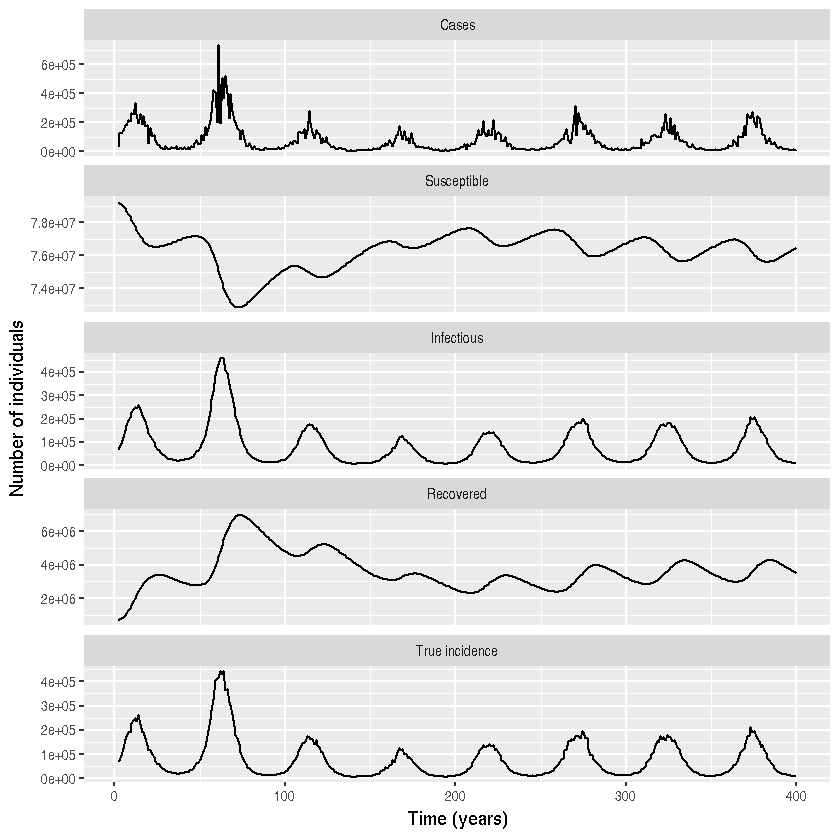

In [9]:
# plotting the simulated trajectory
df <-df%>% melt(id="time")
df$variable <- factor(df$variable)

df %>% mutate(variable = recode(variable, cases = "Cases")) %>% 
  mutate(variable = recode(variable, S = "Susceptible")) %>% 
  mutate(variable = recode(variable, I = "Infectious")) %>% 
  mutate(variable = recode(variable, R = "Recovered")) %>% 
  mutate(variable = recode(variable, H = "True incidence")) %>% 
  ggplot() +
  geom_line(aes(x = time, y = value)) +
  facet_wrap( ~variable, ncol=1, scales =  "free_y")+ 
  xlab("Time (years)") + ylab(" Number of individuals")